# Decision Trees

## Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import datetime as dt
import os
import seaborn as sns
import random 

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_theme()
sns.set_palette("tab20")
sns.set_style("darkgrid", rc = {"grid.color": "white"})
c10 = sns.color_palette("tab10").as_hex()[:]
c20 = sns.color_palette("tab20").as_hex()[:]

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
os.chdir('/Users/maris/Documents/FE800')

In [7]:
np.random.seed(10)

## Import Data

In [8]:
df = pd.read_pickle("fe800_data.pkl").drop(['RunningCoupon', 'ParSpread', 'CDSRealRecovery',
       'UpfrontBASpreadAverage', 'ConvBASpreadAverage', 'EstimatedNotional',
       'WklyNetNotional', 'DP', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC'], axis = 1)
df.head()

Price    Volume  Trades    Return       Age        TTM  \
cusip     trd_dt                                                                
00206RBH4 2018-07-02  86.132 -0.175980    13.0  0.000000  5.041096  24.471233   
          2018-07-03  86.821 -0.785507     7.0  0.007999  5.043836  24.468493   
          2018-07-05  86.730 -0.573559    24.0 -0.001048  5.049315  24.463014   
          2018-07-06  88.675 -0.637707    11.0  0.022426  5.052055  24.460274   
          2018-07-09  89.397 -0.115591     7.0  0.008142  5.060274  24.452055   

                      Stock_Return  Stock_Volume  ETF_Return        PV  \
cusip     trd_dt                                                         
00206RBH4 2018-07-02      0.000000      0.043275    0.000000       NaN   
          2018-07-03      0.015523     -0.171355   -0.005025  0.004849   
          2018-07-05     -0.003363     -0.086349    0.004959  0.001749   
          2018-07-06      0.002454      0.232636    0.007858  0.001668   
          2018-07-09      0.004123      0.357721    0.011967 -0.002931   

                           YTM   Duration      DV01   Convexity  
cusip     trd_dt                                                 
00206RBH4 2018-07-02  0.054010  16.324665 -1.406076  339.273017  
          2018-07-03  0.053445  16.343155 -1.418929  339.790490  
          2018-07-05  0.053541  16.344714 -1.417577  339.812463  
          2018-07-06  0.051959  16.349071 -1.449754  339.925850  
          2018-07-09  0.051410  16.326755 -1.459563  339.254704

In [9]:
macro_factors = pd.read_pickle("macro_factors.pkl").pct_change().drop(["Lower_Target", "Upper_Target"], axis = 1)
macro_factors.head()

,EFFR,1YRT,2YRT,3YRT,5YRT,7YRT,10YRT,30YRT,SPY,LQD
2018-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,0.0,-0.004274,-0.015564,-0.007547,-0.010909,-0.014134,-0.013937,-0.010033,-0.003531,0.003677
2018-07-05,0.0,-0.004292,0.007905,0.007605,0.007353,0.003584,0.003534,-0.003378,0.008158,0.003140
2018-07-06,0.0,0.008621,-0.007843,-0.003774,-0.010949,-0.007143,-0.007042,-0.003390,0.008458,0.001391
2018-07-09,0.0,0.000000,0.015810,0.007576,0.014760,0.014388,0.014184,0.006803,0.009004,0.000695


# Decision Trees

In [87]:
def run_decision_tree(df, feature, max_depth=None):
    X = df.drop([feature, "Price"], axis=1)[1:].fillna(0)
    Y = df[feature][1:].fillna(0)

    X_train = X.loc[:pd.Timestamp("2022-05-31")]
    X_test = X.loc[pd.Timestamp("2022-06-01"):]
    Y_train = Y.loc[:pd.Timestamp("2022-05-31")]
    Y_test = Y.loc[pd.Timestamp("2022-06-01"):]

    dt_model = DecisionTreeRegressor(max_depth=max_depth)
    dt_model.fit(X_train, Y_train)
    
    Y_pred = dt_model.predict(X_test)
    r2_train = dt_model.score(X_train, Y_train)
    r2_test = r2_score(Y_test, Y_pred)

    prices = pd.DataFrame({"Test": df["Price"].loc[pd.Timestamp("2022-06-01"):]}).ffill()
    prices["Return Pred"] = Y_pred + 1

    pred = []
    for i in range(len(prices)):
        if i == 0:
            pred.append(prices["Return Pred"].iloc[0] * df["Price"].loc[pd.Timestamp("2022-05-31")])
        else:
            pred.append(prices["Return Pred"].iloc[i] * prices["Test"].iloc[i - 1])
    prices["Pred"] = pred
    
    mse = mean_squared_error(prices["Test"], prices["Pred"])
    rmse = mean_squared_error(prices["Test"], prices["Pred"], squared=False)
    mae = mean_absolute_error(prices["Test"], prices["Pred"])

    plt.figure(figsize=(12, 6))
    plot_tree(dt_model, filled=True, feature_names=list(df.drop([feature, "Price"], axis=1).columns), fontsize = 6)
    plt.show()

    return r2_train, r2_test, mse, rmse, mae

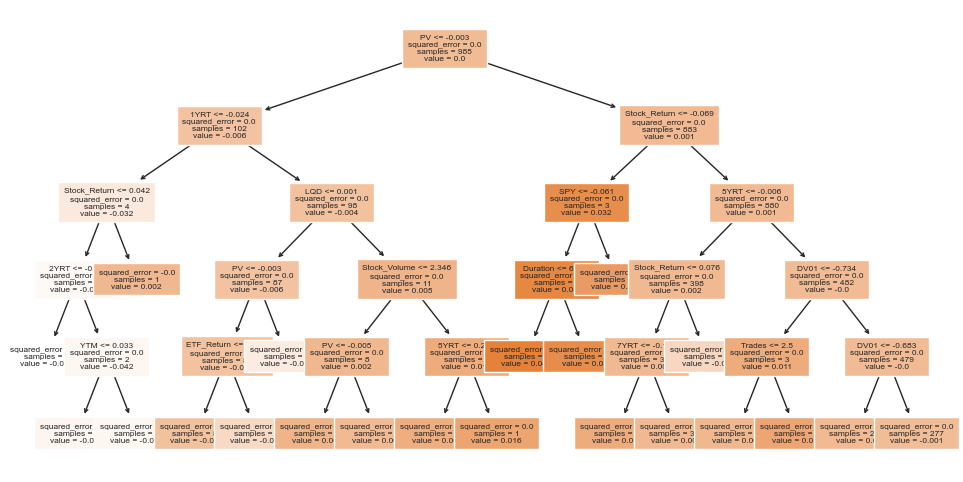

CPU times: user 973 ms, sys: 18.4 ms, total: 991 ms
Wall time: 495 ms


(0.4624005845459698,
 0.0818807686269758,
 0.17023228403359406,
 0.4125921521716016,
 0.29015476631807124)

In [93]:
%%time

run_decision_tree(pd.concat([df.loc[random.sample(list(df.index.droplevel(1).unique()), 1)[0]],  macro_factors], axis = 1), "Return", max_depth = 5)

In [55]:
%%time

results = pd.DataFrame(columns = ["Cusip", "R2 Train", "R2 Test", "MSE", "RMSE", "MAE"])
for col in list(df.index.droplevel(1).unique()):
    outputs = run_decision_tree(pd.concat([df.loc[col],  macro_factors], axis = 1), "Return")
    results.loc[len(results)] = [col, outputs[0], outputs[1], outputs[2], outputs[3], outputs[4]]

CPU times: user 18.7 s, sys: 221 ms, total: 18.9 s
Wall time: 20.2 s


In [56]:
results.drop(["Cusip"], axis = 1).mean()

R2 Train     1.000000
R2 Test    -21.632707
MSE         15.330040
RMSE         2.216415
MAE          1.649390
dtype: float64

In [ ]:
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Load the Boston Housing dataset for demonstration purposes
boston = load_boston()
X, y = boston.data, boston.target

# Create and fit a DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X, y)

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(regressor, filled=True, feature_names=boston.feature_names)
plt.show()
